# AB Testing for Mobil games (complete version) - Cookie Cats

This notebook explores a dataset containing information about the users of a videogame. The code first explores the data and then analyses the results of an A/B testing.

# Table of Contents

- [Import libraries](#import-libraries)
- [Import Dataset](#import-dataset)
- [Exploratory and Descriptive Analysis](#exploratory-and-descriptive-analysis)
  - [Initial exploration](#initial-exploration)
  - [Group comparison: are the groups homogeneous?](#group-comparison-are-the-groups-homogeneous)
    - [Number of users within each group](#number-of-users-within-each-group)
    - [Analysis of Game Rounds](#analysis-of-game-rounds)
      - [Average number of rounds](#average-number-of-rounds)
      - [Analysis of the marginal distribution of Game Rounds for each group](#analysis-of-the-marginal-distribution-of-game-rounds-for-each-group)
      - [Outliers analysis](#outliers-analysis)
  - [Analysis of the treatment: did the groups receive the treatment?](#analysis-of-the-treatment-did-the-groups-receive-the-treatment)
    - [Number of users that did not complete any round](#number-of-users-that-did-not-complete-any-round)
    - [Number of users that reached the gate (received the treatment) within each group](#number-of-users-that-reached-the-gate-received-the-treatment-within-each-group)
  - [Analysis of Retention (1 and 7 days after downloading the game)](#analysis-of-retention-1-and-7-days-after-downloading-the-game)
    - [Percentage of players that came back after 1 and 7 days](#percentage-of-players-that-came-back-after-1-and-7-days)
  - [EDA conclusions (Business Insights so far)](#eda-conclusions-business-insights-so-far)
- [Hypothesis testing](#hypothesis-testing)
  - [Dividing Dataset in Group A and B](#Dividing-Dataset-in-Group-A-and-B)
  - [Difference in Means of Independent groups (variable: sum_gamerounds)](#Difference-in-Means-of-Independent-groups-(variable:-sum_gamerounds))
    - [Relevant libraries](#Relevant-libraries)
    - [ShapiroWilk Test](#ShapiroWilk-Test)
    - [Levene test](#Levene-test)
    - [Hypothesis testing with Mann Whitney U Test](#Hypothesis-testing-with-Mann-Whitney-U-Test)
- [Conclusions](#conclusions)

# Import Libraries

In [9]:
# General
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis testing
from scipy.stats import shapiro
import scipy.stats as stats

# Import Dataset

In [10]:
# File's path
path = '.\datasets\cookie_cats.csv'

# We make the importing code file type agnostic
if path[-3::] == 'csv':
    df = pd.read_csv(path)   
elif path[-3::] == 'xlsx':
    df = pd.read_excel(path)

# Exploratory and Descriptive Analysis

## Initial exploration

The dataset is composed by 5 variables and 90189 observations. The variables can be defined as follows:
- `userid`: unique number to identify each user
- `version`: two groups in which the users were divided to run the test. One group received the treatment when reaching level 30. The other on level 40.
- `sum_gamerounds`: number of rounds the user has passed.
- `retention_1`: True if he used the game during the next day after installing it. False otherwise.
- `retention_7`: True if he used the game during the day 7 after installing it. False otherwise.

In [11]:
print(df.shape)
df.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The following code shows that there are no nun-values, as well as the type of each variable and the unique values within each column.

In [12]:
df_info = pd.DataFrame(index=df.columns)

df_info['Non-Null'] = df.notnull().sum()
df_info['Dtype'] = df.dtypes
df_info['Unique Values'] = df.nunique()
df_info

,Non-Null,Dtype,Unique Values
userid,90189,int64,90189
version,90189,object,2
sum_gamerounds,90189,int64,942
retention_1,90189,bool,2
retention_7,90189,bool,2


The statistics of the only two `int` variables are shown below.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


## Group comparison: are the groups homogeneous?

In A/B testing, in order to eliminate (or at least diminish) the effect of confounding variables, it is necessary to have homogeneous control and testing groups. This sections explores if this requirement is met. 

### Number of users within each group

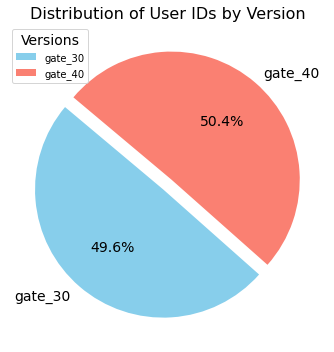

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64


In [14]:
grouped_data = df.groupby('version').count()['userid']

# Set color theme for the chart
colors = ['skyblue', 'salmon']

# Creating a more visually appealing pie chart
plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(grouped_data, labels=grouped_data.index, colors=colors, startangle=140, autopct='%1.1f%%', explode=[0.05, 0.05])

# Enhance font size for readability
for text in texts:
    text.set_fontsize(14)
for autotext in autotexts:
    autotext.set_fontsize(14)

# Adding a title with a larger font size
plt.title('Distribution of User IDs by Version', fontsize=16)

# Optional: Adding a legend
plt.legend(grouped_data.index, title="Versions", title_fontsize=14, loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()

# Print the grouped data
print(grouped_data)

### Analysis of Game Rounds

#### Average number of rounds

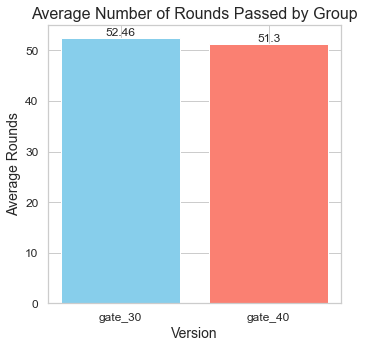

version
gate_30    52.456264
gate_40    51.298776
Name: sum_gamerounds, dtype: float64


In [15]:
grouped_data = df.groupby('version').mean()['sum_gamerounds']

# Set a style using seaborn for more appealing aesthetics
sns.set(style="whitegrid")

# Creating the bar chart
plt.figure(figsize=(5, 5))
bars = plt.bar(grouped_data.index, height=grouped_data, color=['skyblue', 'salmon'])

# Adding details to make the chart more informative and visually appealing
plt.title('Average Number of Rounds Passed by Group', fontsize=16)
plt.xlabel('Version', fontsize=14)
plt.ylabel('Average Rounds', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding the value on top of each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Print the grouped data
print(grouped_data)

#### Analysis of the marginal distribution of Game Rounds for each group

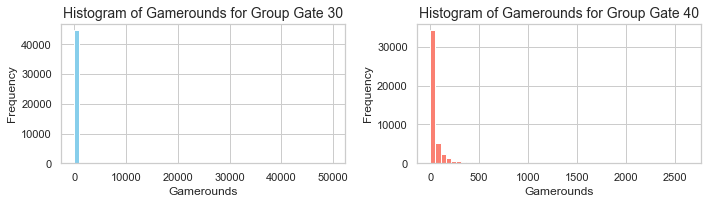

In [16]:
# Set a style using seaborn for a more consistent and appealing look
sns.set(style="whitegrid")

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram for gate_30
df[df.version == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="skyblue", bins=50)
axes[0].set_title('Histogram of Gamerounds for Group Gate 30', fontsize=14)
axes[0].set_xlabel('Gamerounds', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Histogram for gate_40
df[df.version == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="salmon", bins=50)
axes[1].set_title('Histogram of Gamerounds for Group Gate 40', fontsize=14)
axes[1].set_xlabel('Gamerounds', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Adjusting the layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
df.groupby("version")['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


#### Outliers analysis

In [18]:
df.sort_values(by='sum_gamerounds', ascending=False)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
...,...,...,...,...,...
59687,6610805,gate_30,0,False,False
23707,2639282,gate_40,0,False,False
59670,6608718,gate_30,0,False,False
59645,6604544,gate_30,0,False,False


In [19]:
df.drop(57702, inplace=True)

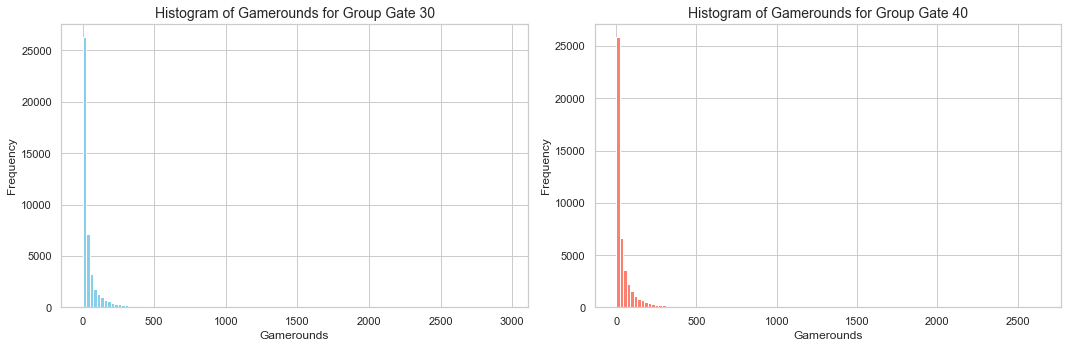

In [20]:
# Set a style using seaborn for a more consistent and appealing look
sns.set(style="whitegrid")

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram for gate_30
df[df.version == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="skyblue", bins=120)
axes[0].set_title('Histogram of Gamerounds for Group Gate 30', fontsize=14)
axes[0].set_xlabel('Gamerounds', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Histogram for gate_40
df[df.version == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="salmon", bins=120)
axes[1].set_title('Histogram of Gamerounds for Group Gate 40', fontsize=14)
axes[1].set_xlabel('Gamerounds', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Adjusting the layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()

## Analysis of the treatment: did the groups received the treatment?

### Number of users that did not complete any round

In [21]:
df_zero = df[df['sum_gamerounds']==0]

n_non_players = df_zero.groupby('version').count()['userid']
n_non_players

version
gate_30    1937
gate_40    2057
Name: userid, dtype: int64

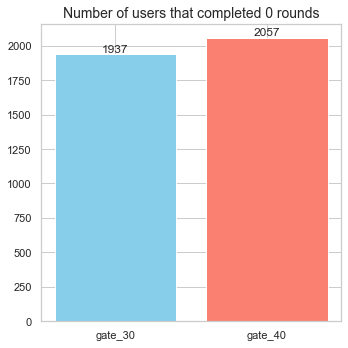

In [22]:
plt.figure(figsize=(5, 5))
bars = plt.bar(n_non_players.index, height=n_non_players, color=['skyblue', 'salmon'])

# Adding the value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Number of users that completed 0 rounds', fontsize=14)   
# Show the plot
plt.tight_layout()
plt.show()

### Number of users that reached the gate (received the treatment) within each group

In [23]:
filt_gate_30 = (df['version'] == 'gate_30')
filt_gate_40 = (df['version'] == 'gate_40')

filt_sum_rounds_30 = df['sum_gamerounds']>=30
filt_sum_rounds_40 = df['sum_gamerounds']>=40

df_30 = df[filt_gate_30 & filt_sum_rounds_30]
df_40 = df[filt_gate_40 & filt_sum_rounds_40]

In [24]:
gate_players = pd.Series([len(df_30), len(df_40)], index=['gate_30', 'gate_40'])

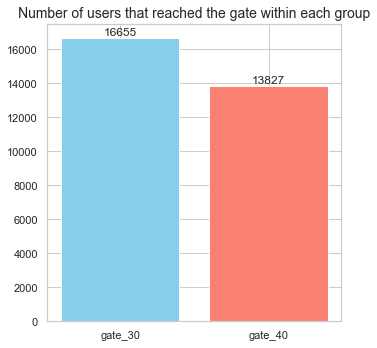

In [25]:
plt.figure(figsize=(5, 5))
bars = plt.bar(gate_players.index, height=gate_players, color=['skyblue', 'salmon'])

# Adding the value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Number of users that reached the gate within each group', fontsize=14)   
# Show the plot
plt.tight_layout()
plt.show()

## Analysis of Retention (1 and 7 days after downloading the game)

### Percentage of players that came back after 1 and 7 days

In [26]:
print('Number of users that came back after 1 and 7 days:')
display(df.groupby('version').sum()[['retention_1', 'retention_7']])
print('\n')
print('% over the total number of users:')
round(df.groupby('version').mean()[['retention_1', 'retention_7']]*100,2)

Number of users that came back after 1 and 7 days:


,retention_1,retention_7
version,,
gate_30,20034,8501
gate_40,20119,8279




% over the total number of users:


,retention_1,retention_7
version,,
gate_30,44.82,19.02
gate_40,44.23,18.20


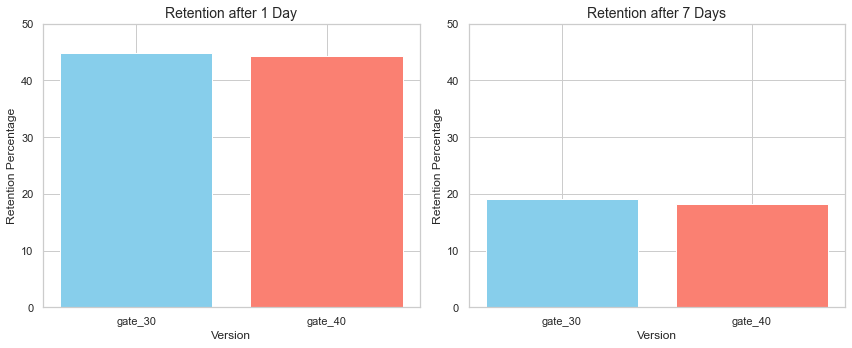

In [27]:
# Calculating mean and rounding
mean_retention = round(df.groupby('version').mean()[['retention_1', 'retention_7']] * 100, 2)

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot for retention_1
axes[0].bar(mean_retention.index, mean_retention['retention_1'], color=['skyblue', 'salmon'])
axes[0].set_title('Retention after 1 Day', fontsize=14)
axes[0].set_xlabel('Version')
axes[0].set_ylabel('Retention Percentage')
axes[0].set_ylim(0, 50)

# Bar plot for retention_7
axes[1].bar(mean_retention.index, mean_retention['retention_7'], color=['skyblue', 'salmon'])
axes[1].set_title('Retention after 7 Days', fontsize=14)
axes[1].set_xlabel('Version')
axes[1].set_ylabel('Retention Percentage')
axes[1].set_ylim(0, 50)  

# Adjusting layout and showing plot
plt.tight_layout()
plt.show()

## EDA conclusions (Business Insights so far)

**Summary of the findings:**
- The users have been divided by approximately half in control (gate_30) and treatment (gate_40) group.
- After dropping the main outlier, the groups follow a similar distribution in terms of number of game rounds per user and number of users that did not complete any round. 
- The number of users within the gate_30 group that reached the gate is higher in group gate_30 than in group gate_40. This was expected since the latter group needs to have played 10 more rounds to reached the gate. However, the number of people that reached the gate (and therefore received the treatment) in both groups are very numerous (16k and almost 14k, rspectively).
- Both groups present similar 1-day and 7-day retention rates, but the gate_40 group presents a slighly lower retention rate for both time horizons.

**Main conclusions:**
- The groups are quite homogeneous, which allows to conduct the A/B testing.
- An hyopthesis testing can be conducted to assess whether the difference in the retention rate between groups is statistically significant. 

# Hypothesis testing

## Dividing Dataset in Group A and B

In [28]:
df_A = df[df['version']=='gate_30'].copy()
df_B = df[df['version']=='gate_40'].copy()

In [29]:
# Check
len(df) == len(df_A) + len(df_B)

True

## Difference in Means of Independent groups (variable: sum_gamerounds)

**We will conduct the following steps:**
* Check if the variable to test follows a normal distribution in both groups (Shapiro-Wilk Test). <br>


    - If it does not follow a normal distribution:
        * Conduct a non-parametric test (Mann Whitney U Test).
 
    - If it follows a normal distribution:
        * Check Homogeneity of Variances (Levene's test). 
            * If variances are not homogeneous: Conduct a T-test. 
            * If variances are homogeneous: Conduct a Welch Test. 


### Relevant libraries

In [30]:
from scipy.stats import shapiro
import scipy.stats as stats

### ShapiroWilk Test

From the histograms above, we can deduce that the distribution of the variable `sum_gamerounds` is not normal in either of the groups. However, we can run a Shapiro test to confirm the non-normality of the variable. The test must be interpreted as follows:
- Ho: The variable follows a normal distribution
- Ha: The variable does not follow a normal distribution

In [31]:
norm_A = shapiro(df_A["sum_gamerounds"])[1]
norm_B = shapiro(df_B["sum_gamerounds"])[1]

print(f'P-value of Shapiro test for Group A: {norm_A}')
print(f'P-value of Shapiro test for Group B: {norm_B}')
print('\n')

if (norm_A > 0.05) & (norm_B > 0.05):
    print('Therefore, the variable follows a normal distribution in both groups.')
else:
    print('Therefore, the variable does not follow a normal distribution in one or both of the groups.')

P-value of Shapiro test for Group A: 0.0
P-value of Shapiro test for Group B: 0.0


Therefore, the variable does not follow a normal distribution in one or both of the groups.


C:\Users\Manuel\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Levene test

Since the variable does not follow a normal distribution, we have to conduct a non-parametric test. Here, we implement a Mann Whitney U Test.

### Hypothesis testing with Mann Whitney U Test

In [32]:
ttest = stats.mannwhitneyu(df_A['sum_gamerounds'], df_B['sum_gamerounds'])
ttest
alpha = 0.10

if ttest[1] >= alpha:
    print(f'The p-value of the test is {ttest[1]:.2}. Therefore, we fail to reject the Null-Hypothesis at {alpha*100:.3}% level of significance.')
else:
    print(f'The p-value of the test is {ttest[1]:.2}. Therefore, we reject the Null-Hypothesis at {alpha*100:.3}% level of significance.')

The p-value of the test is 0.051. Therefore, we reject the Null-Hypothesis at 10.0% level of significance.


**Note**: We could also use the CLT and conduct a T-test since the sample is quite big.

# Conclusions

The experiment demonstrates with 90% confidence that introducing the gate at level 40 significantly impacts player retention. Essentially, players facing the gate at level 30 are more inclined to play additional levels compared to those encountering it at level 40. This phenomenon aligns with the 'theory of hedonic adaptation', suggesting that continuous play diminishes enjoyment. Introducing a break at the gate helps maintain interest, but a later gate at level 40 leads to earlier player drop-off due to reduced engagement.